# Test SoilGrids v2 access through Earth Engine

https://git.wur.nl/isric/soilgrids/soilgrids.notebooks/-/blob/master/markdown/access_on_gee.md

#### Run zonal stats for SIBBORK sites

In [153]:
import os, sys
import ee
import geopandas as gpd
import pandas as pd

In [ ]:
!pip install geemap

### Authenticate current access to Google Earth Engine
Make a current credentials file; copy it to private bucket; get its s3 path to pass to script 

In [ ]:
ee.Authenticate()

In [158]:
ee.Initialize()

In [155]:
import geemap

In [156]:
Map = geemap.Map()
Map

Map(center=[20, 0], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=HBox(children=(Togg…

In [121]:
# # Add Earth Engine dataset
# SOIL_VAR_NAME = "cec"
# data = ee.Image(f"projects/soilgrids-isric/{SOIL_VAR_NAME}_mean")

# BANDNAME = f"{SOIL_VAR_NAME}_0-5cm_mean"

# # Set visualization parameters.
# data_vis = {
#     "bands":[BANDNAME],
#     'min': 0,
#     'max': 800,
#     'palette': ['006633', 'E5FFCC', '662A00', 'D8D8D8', 'F5F5F5'],
# }

# # Add Earth Engine DEM to map
# Map.addLayer(data, data_vis, f'SoilGrid v2: {BANDNAME}')

### Read the input zones file

In [178]:
input_zones_fn = "/projects/my-public-bucket/footprints_LCunmasked.gpkg"

footprints_sibbork_gdf = gpd.read_file(input_zones_fn)

# convert to FeatureCollection using one line of code
footprints_sibbork_fc = geemap.geopandas_to_ee(footprints_sibbork_gdf)

Map.addLayer(footprints_sibbork_fc, {"color":"red"}, 'SIBBORK sites TTE')

### Set some zonal stats arguments

In [216]:
STATS_TYPE = 'MEDIAN'
SCALE = 250
# out_dir = '/projects/my-public-bucket/test_geemap_zonal'
# if not os.path.exists(out_dir):
#     os.makedirs(out_dir)

In [217]:
ee.Image('projects/soilgrids-isric/bdod_mean').bandNames().getInfo()

['bdod_0-5cm_mean',
 'bdod_5-15cm_mean',
 'bdod_15-30cm_mean',
 'bdod_30-60cm_mean',
 'bdod_60-100cm_mean',
 'bdod_100-200cm_mean']

### Run zonal stats across all layers of SoilGrids V2 and append to the input geodataframe

In [226]:
SOILGRIDS_LAYER_LIST = ["bdod","cec","cfvo","clay","nitrogen","ocd","ocs","phh2o","sand","silt","soc"]
df_list = []

for SOILGRID in SOILGRIDS_LAYER_LIST:
    
    data = ee.Image(f"projects/soilgrids-isric/{SOILGRID}_mean")

    out_stats_fn = os.path.join(out_dir, f'zonal_stats_{STATS_TYPE}_{SCALE}_{SOILGRID}' + '.csv')

    # Allowed output formats: csv, shp, json, kml, kmz
    # Allowed statistics type: MEAN, MAXIMUM, MINIMUM, MEDIAN, STD, MIN_MAX, VARIANCE, SUM
    df = geemap.zonal_statistics(data, footprints_sibbork_fc, out_stats_fn, statistics_type=STATS_TYPE, scale=SCALE, return_fc=True)
    df = geemap.ee_to_pandas(df)
    df_list.append(df.drop(columns=COLS_LIST[0:-1]))
    
df = pd.concat(df_list, axis = 1).T.drop_duplicates().T

Computing statistics ...
Computing statistics ...
Computing statistics ...
Computing statistics ...
Computing statistics ...
Computing statistics ...
Computing statistics ...
Computing statistics ...
Computing statistics ...
Computing statistics ...
Computing statistics ...


# Another dataset: TTE forest pattern

In [162]:
ASSET_PATH = 'projects/foreststructure/TTE_DATA_v201902v2'

In [177]:
ee.Image(ASSET_PATH).bandNames().getInfo()

['tte_domain', 'tte_zones', 'tte_abruptness', 'tte_classification', 'tcc']

In [227]:
data = ee.Image(ASSET_PATH)

#out_stats_fn = os.path.join(out_dir, f'zonal_stats_{STATS_TYPE}_{SCALE}_{BAND}' + '.csv')
out_stats_fn = os.path.join(out_dir, f'zonal_stats_{STATS_TYPE}_{SCALE}' + '.csv')

# Allowed output formats: csv, shp, json, kml, kmz
# Allowed statistics type: MEAN, MAXIMUM, MINIMUM, MEDIAN, STD, MIN_MAX, VARIANCE, SUM
df_tte = geemap.zonal_statistics(data, footprints_sibbork_fc, out_stats_fn, statistics_type=STATS_TYPE, return_fc=True)
df_tte = geemap.ee_to_pandas(df_tte)

Computing statistics ...


In [228]:
df_tte.head()

,tte_domain,tte_zones,tte_abruptness,tte_classification,tcc,file,site_cnt_h5,name,area_ha,area_km2,site_sim_status,site_cnt_stemmap_yrs
0,NaN,NaN,NaN,NaN,NaN,arcticDEM_Creamer_823_1_49_10m_mf300_LCunmaske...,0,Creamer_823_1_49,900,9,incomplete,0
1,1.0,NaN,NaN,NaN,NaN,arcticDEM_TL_MM27_T1_1_11_10m_mf300_LCunmasked...,3,TL_MM27_T1_1_11,900,9,complete,93
2,1.0,2.0,1.0,7.0,0.0,arcticDEM_ambler_10m_mf300_LCunmasked.tif,3,ambler,900,9,complete,93
3,1.0,1.0,1.0,10.0,0.0,arcticDEM_brooks01_10m_mf300_LCunmasked.tif,3,brooks01,900,9,complete,93
4,1.0,1.0,1.0,7.0,0.0,arcticDEM_brooks02_10m_mf300_LCunmasked.tif,3,brooks02,900,9,complete,93


### Save to gpkg and csv

In [230]:
footprints_sibbork_gdf_soils = pd.concat([gdf, df, df_tte[['tte_abruptness','tcc']] ], axis=1)
#footprints_sibbork_gdf_soils.to_file(os.path.splitext(input_zones_fn)[0] + f'_zonal_stats_{STATS_TYPE}_{SCALE}' + '.gpkg')
#footprints_sibbork_gdf_soils.to_csv(os.path.splitext(input_zones_fn)[0] + f'_zonal_stats_{STATS_TYPE}_{SCALE}' + '.csv')
footprints_sibbork_gdf_soils.head()

,name,file,area_km2,area_ha,site_cnt_h5,site_sim_status,site_cnt_stemmap_yrs,geometry,bdod_0-5cm_mean,bdod_5-15cm_mean,...,silt_60-100cm_mean,silt_100-200cm_mean,soc_0-5cm_mean,soc_5-15cm_mean,soc_15-30cm_mean,soc_30-60cm_mean,soc_60-100cm_mean,soc_100-200cm_mean,tte_abruptness,tcc
0,Creamer_823_1_49,arcticDEM_Creamer_823_1_49_10m_mf300_LCunmaske...,9.0,900.0,0,incomplete,0.0,"POLYGON ((-2699360.000 607680.000, -2699360.00...",54.0,68.0,...,686.0,697.0,2170.000000,1417.443918,584.000000,292.161964,256.666667,254.370370,NaN,NaN
1,TL_MM27_T1_1_11,arcticDEM_TL_MM27_T1_1_11_10m_mf300_LCunmasked...,9.0,900.0,3,complete,93.0,"POLYGON ((-2385410.000 1429930.000, -2385410.0...",64.0,82.0,...,446.0,404.0,2936.000000,2116.667539,1280.420455,969.500000,581.770833,544.000000,NaN,NaN
2,ambler,arcticDEM_ambler_10m_mf300_LCunmasked.tif,9.0,900.0,3,complete,93.0,"POLYGON ((-2292720.000 915650.000, -2292720.00...",57.0,81.0,...,355.0,332.0,2566.287709,1625.681818,828.000000,564.500000,482.576023,500.666667,1.0,0.0
3,brooks01,arcticDEM_brooks01_10m_mf300_LCunmasked.tif,9.0,900.0,3,complete,93.0,"POLYGON ((-2385410.000 637580.000, -2385410.00...",48.0,75.0,...,376.0,336.0,2741.000000,1910.268293,1175.000000,623.000000,573.666667,569.666667,1.0,0.0
4,brooks02,arcticDEM_brooks02_10m_mf300_LCunmasked.tif,9.0,900.0,3,complete,93.0,"POLYGON ((-2388400.000 640570.000, -2388400.00...",51.0,75.0,...,350.0,317.0,2665.336294,1925.356423,1262.000000,905.253071,788.000000,797.743351,1.0,0.0


In [201]:
import plotnine
from plotnine import *

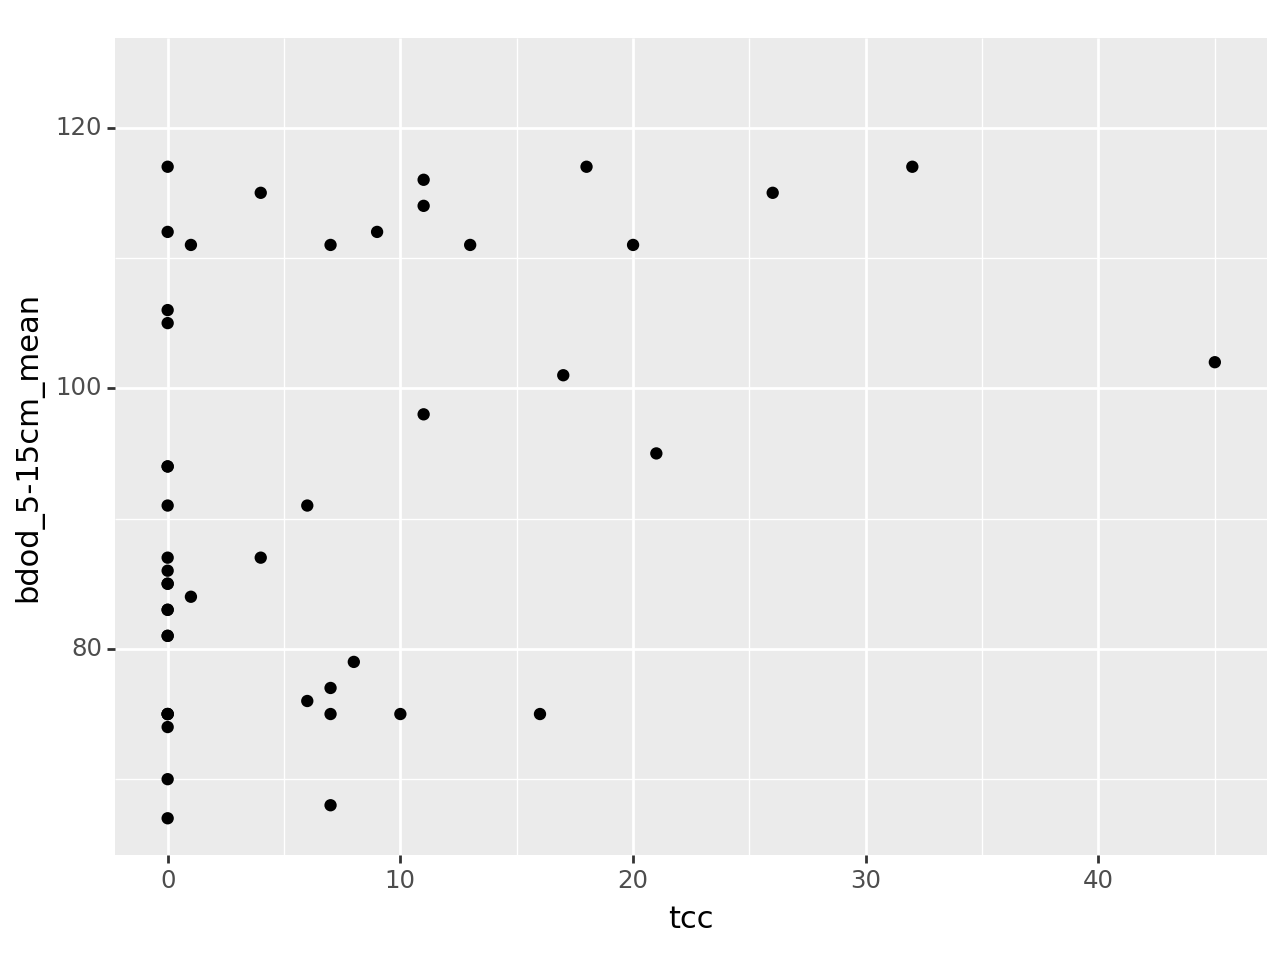

<Figure Size: (640 x 480)>

In [235]:
(
 ggplot(footprints_sibbork_gdf_soils, aes(x='tcc',y='bdod_5-15cm_mean'))
    + geom_point(show_legend=False) 
    #+ geom_label(aes(label='name'))
)